In [6]:
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np

In [7]:
model = VGG16(weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
img_size = (224, 224)
img = image.load_img('../.data/grad_cam/elephants.png', target_size=img_size)
x = image.img_to_array(img).astype(np.uint8)
print(x.shape)
print(np.max(x))
img_normalized = x / 255.

(224, 224, 3)
255


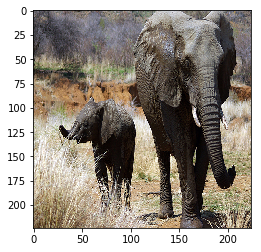

In [9]:
import matplotlib.pyplot as viz

viz.imshow(img_normalized)

In [10]:
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [11]:
predictions = model.predict(x)
print(predictions.shape)

(1, 1000)


In [12]:
print('predictions: {}'.format(decode_predictions(predictions, top=4)[0]))
top_class_index = np.argmax(predictions[0])
print('top class index: {}'.format(top_class_index))

predictions: [('n02504458', 'African_elephant', 0.8600283), ('n01871265', 'tusker', 0.13637426), ('n02504013', 'Indian_elephant', 0.0035892536), ('n01704323', 'triceratops', 1.765387e-06)]
top class index: 386


In [13]:
class_output = model.output[:, top_class_index]  # output entry for the chosen class in prediction vector
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))  # mean intensity of the gradient for each channel

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

print('pooled grads shape: {}, conv layer output shape: {}'.format(pooled_grads_value.shape,
                                                                   conv_layer_output_value.shape))

pooled grads shape: (512,), conv layer output shape: (14, 14, 512)


In [14]:
for i in range(pooled_grads_value.shape[0]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

# equivalent to ReLU, according to paper we are only interested in positive pixels
# i.e. pixels whose intensity should be increased to increase y corresponding to chosen class
# negative pixels are likely to belong to other categories in the image
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

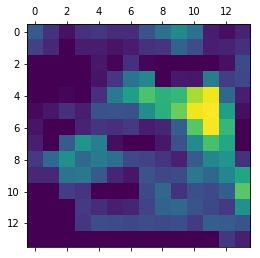

In [15]:
viz.matshow(heatmap)

In [16]:
# let's do it without opencv
# before converting to image have to add channel dimension to array
heatmap_img = image.array_to_img(np.expand_dims(heatmap, axis=-1))

(224, 224, 1)
1.0


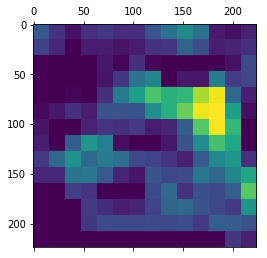

In [17]:
# resize heatmap
heatmap_img = heatmap_img.resize(img_size)
heatmap_grayscale = image.img_to_array(heatmap_img) / 255.
print(heatmap_grayscale.shape)
print(np.max(heatmap_grayscale))
viz.matshow(heatmap_grayscale[:, :, 0])

(224, 224, 4)


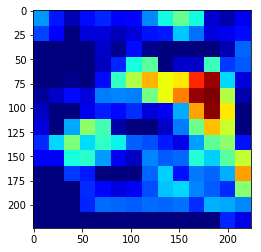

In [18]:
colormap = viz.get_cmap('jet')
heatmap_jet = colormap(heatmap_grayscale[:, :, 0])
print(heatmap_jet.shape)
viz.imshow(heatmap_jet)

In [19]:
heatmap_jet = heatmap_jet[:, :, :3]
print(heatmap_jet.shape)
print(np.max(heatmap_jet))

(224, 224, 3)
1.0


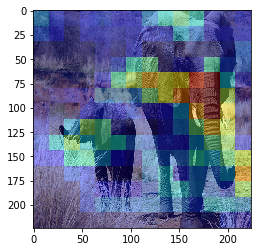

In [20]:
img_superimposed = heatmap_jet * 0.4 + img_normalized * 0.6
viz.imshow(img_superimposed)